# Clustering

In this course we go through clustering methods. It is divided into few parts:
1. Distributed clustering (042Clustering_Distributed notebook): 
    - K-means (HCM)
    - Fuzzy clustering (FCM)
    - Possibilistic clustering (PCM)
2. Density-based clustering (043Clustering_Density notebook)
3. Hierarhical clustering (044Clustering_Hierarchical notebook): 
    - agglomerative
    - divisive
4. Quality metrics (045Clustering_Quality notebook)
5. Use case: Image segmentation (046Clustering_ImageSegmentation notebook)

## Idea 

The goal of clustering is to use unsupervised data set, means data set without labels, and find similarities between objects in this data set, and put the most similar to each other together into a cluster. 

Let's imagine that we have a data set with only two features (two axis). The objects does not have any label assigned as in the figure below.
![](./../images/clustering.png)

The clustering training divided the data set into clusters of similar objects. The number of clusters is parametrized in most methods, but there are methods where instead of cluster number, other parameters needs to be set. Such example are density-based methods.

In the figure below, we clustered the data set into two clusters of similar objects.

![](./../images/clustering_done.png)

## Libraries

We need four libraries. Numpy is used for the matrices calculation. The math library is used to calcualte the square root when we calculate the Euclidean distance. Matplotlib is used for the plots. Finally, pandas is used here only for displaying the membership matrix in a easy to ready form in Jupyter. Pydot enables to use graphviz to visualize a dendrogram.

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from math import sqrt
import pydot
import math
from IPython.display import Image
from PIL import Image
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

## Data set

Let's use the data set as in the table below.

|**Aircraft name** | **Distance range (km)** | **Seats count** | **Aircraft type** |
|------------------|-------------------------|-----------------|-------------------|
| Cesna 510 Mustang| 1940                    |             4   | private jet       |
| Falcon 10/100    | 2960                    |             9   | private jet       |
| Hawker 900/900XP | 4630                    |             9   | private jet       |
| ATR 72-600       | 1528                    |            78   | medium size aircraft|
| Bombardier Dash 8 Q400 | 2040              |            90   | medium size aircraft|
| Embraer ERJ145 XR| 3700                    |            50   | medium size aircraft|
| Boeing 747-8     | 14815                   |           467   | jet airliner      |
| A380-800         | 15200                   |           509   | jet airliner      |
| Boeing 787-8     | 15700                   |           290   | jet airliner      |
| Boeing 737-900ER | 6045                    |           215   | jet airliner      | 

To plot the libraries matplotlib is used. Numpy is used for easier matrix manipulation. Pandas is used to display the matrices in a nice looking form in Jupyter.

Now, we are ready to plot:

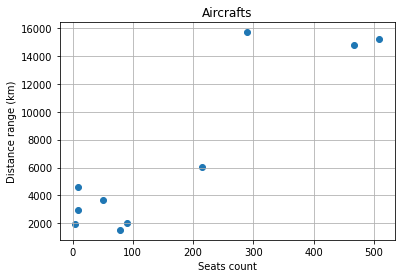

In [21]:
X=np.array([(4,1940),(9,2960),(9,4630),(78,1528),(90,2040),(50,3700),(467,14815),(509,15200),(290,15700),(215,6045)])

x1 = np.array(X[:,0])
x2 = np.array(X[:,1])

fig, ax = plt.subplots()
ax.scatter(x1,x2)
ax.set(xlabel='Seats count', ylabel='Distance range (km)',
       title='Aircrafts')
ax.grid()
plt.show()

Before we go to the next step, we need to normalize our dataset:

In [22]:
train_data = np.array(X)
max_values = train_data.max(0)

data_set = np.divide(train_data,max_values)

Now, the data is between 0 and 1:

In [23]:
pd.DataFrame(data_set, columns = ['Seats count','Distance range (km)'])

,Seats count,Distance range (km)
0,0.007859,0.123567
1,0.017682,0.188535
2,0.017682,0.294904
3,0.153242,0.097325
4,0.176817,0.129936
5,0.098232,0.235669
6,0.917485,0.943631
7,1.000000,0.968153
8,0.569745,1.000000
9,0.422397,0.385032


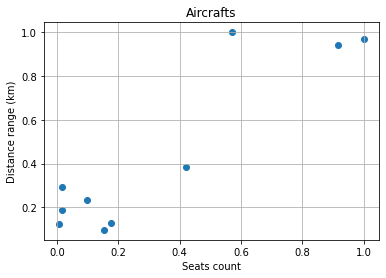

In [24]:
x1 = np.array(data_set[:,0])
x2 = np.array(data_set[:,1])

fig, ax = plt.subplots()
ax.scatter(x1,x2)
ax.set(xlabel='Seats count', ylabel='Distance range (km)',
       title='Aircrafts')
ax.grid()
plt.show()

The ``data_set`` variable is used in all further examples. We can store it in this notebook and restore it in each next notebook. This reduce the amount of code that needs to be written.

In [25]:
%store data_set

Stored 'data_set' (ndarray)


## Distributed clustering

We have many types of distributed clustering, where most are an modification of k-means. In this section we show three types: hard k-means (hcm), fuzzy k-means (fcm) and possibilistic k-means (pcm).

### K-means

The most known method is called k-means and assign each case to one cluster strictly. It is also known as hard c-means where k is the same as c and are the number of clusters that we are willing to divide the data set to. The steps of hcm are like following:
1. choose the entrance cluster centroids,
2. item calculate the membership matrix $U$,
3. item calculate new centroids matrix $V$,
4. calculate the difference between previously membership matrix $U$ and the new one calculated in current iteration.

Before we start, we should setup a few variables like the membership matrix, number of clusters, the error margin and feature space:

In [26]:
groups = 2
error_margin = 0.01
m=2
membership=np.zeros((len(data_set),groups))

The error margin is a value of error that below ends the clustering loop. 

The membership matrix if filled with zeros as we don't have any guess for assignation yet. We can also fill it randomly with 1 and 0 for each group. The membership matrix looks like following:

\begin{equation*}
U=\begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
\end{bmatrix}.
\end{equation*}


It's time to generate centroid array randomly:
\begin{equation}
 V=[v_{1},v_{2},\ldots,v_{c}].
\end{equation}

We go through each group and add a random array of the feature space centroid positions:

In [27]:
def select_centers():
    return np.random.rand(groups,len(data_set[0]))
        
centers = select_centers()

Let's take a look what centroids do we have:

In [28]:
pd.DataFrame(centers, columns=['x1','x2'])

,x1,x2
0,0.521535,0.098609
1,0.753853,0.545026


We can also set fixed centers. It is important that the values are normalized.

In [29]:
#centers = [[0.2,0.2],  [0.8,0.8]]
#pd.DataFrame(centers)
#print(centers)

To check what is the distance between the centroids and the elements of data set we use the Euclidean distance:

\begin{equation}
 \rho_{Min}(x_{i},v_{j})=\sqrt{\sum_{i=1}^{d}(x_{i}-v_{j})^{2}}.
\end{equation}

In [30]:
def calculate_distance(x,v):
    return sqrt((x[0]-v[0])**2+(x[1]-v[1])**2)

The next step is to calculate the new membership matrix:

\begin{equation}
 \mu_{ik}^{(t)}=
 \begin{cases}
 1 & \text{if } d(x_{k},v_{i})<d(x_{k},v_{j}),  \text{for each } j\neq i\\
 0 & \text{in other case} \\
 \end{cases}.
\end{equation}

The code below relizes the equation above for two groups.

In [31]:
def calculate_u(x, centers):
    if calculate_distance(x, centers[0]) < calculate_distance(x, centers[1]):
        return [1,0]
    else:
        return [0,1]

The third step is to calculate new centroids based on the new membership matrix $U$:

\begin{equation}
 v_{i}=\frac{\sum_{k=1}^{M}\mu_{ik}^{(t)}x_{k}}{\sum_{k=1}^{M}\mu_{ik}^{(t)}}.
\end{equation}

The calculation is done in two steps: ```u_x_vector``` and ```u_scalar```:

In [32]:
def calculate_new_centers(u):
    new_centers=[]
    for c in range(groups):
        new_centers.append(np.divide(np.dot(np.square(np.array(u)[:, c]), data_set),np.sum(np.square(np.array(u)[:, 1]))))
    return new_centers

We are almost done here. The last step before we cluster is to set the rule that allow us to stop the loop.

In [34]:
def calculate_differences(new_membership, membership):     
    return np.sum(np.abs(np.subtract(membership,new_membership)))

It's time to combine all together:

In [35]:
def cluster_hcm(membership,centers):
    difference_limit_not_achieved=True
    new_centers = centers
    iter=0
    while difference_limit_not_achieved:
        new_membership=[]
        for i in range(len(data_set)):
            new_membership.append(calculate_u(data_set[i], new_centers))
        new_centers = calculate_new_centers(new_membership)
        if iter>0:
            if calculate_differences(new_membership, membership) < error_margin:
                difference_limit_not_achieved=False
        membership=new_membership
        iter=iter+1
    return new_membership, new_centers

Ready to build some new clusters: 

In [37]:
new_membership_hcm, new_centers_hcm = cluster_hcm(membership, centers)
%store new_membership_hcm
%store new_centers_hcm

Stored 'new_assignation_hcm' (list)
Stored 'new_centers_hcm' (list)


The centers are like following:

In [38]:
pd.DataFrame(new_centers_hcm, columns=['x1','x2'])

,x1,x2
0,0.127701,0.207853
1,0.829077,0.970594


And the membership matrix looks like:

In [39]:
pd.DataFrame(new_membership_hcm, columns = ['Cluster 1','Cluster 2'])

,Cluster 1,Cluster 2
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,0,1
7,0,1
8,0,1
9,1,0


To plot it, we need to develop a short function that adds some colors to our plot:

In [40]:
red = data_set[np.where(np.array(new_membership_hcm)[:,0]==1)]
blue = data_set[np.where(np.array(new_membership_hcm)[:,1]==1)]

And finally plot the results:

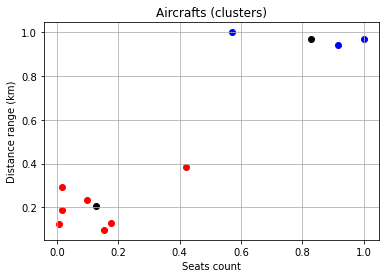

In [41]:
fig, ax = plt.subplots()

ax.scatter(blue[:,0],blue[:,1],c='blue')
ax.scatter(red[:,0],red[:,1],c='red')
ax.scatter(np.array(new_centers_hcm)[:,0],np.array(new_centers_hcm)[:,1],c='black')
ax.set(xlabel='Seats count', ylabel='Distance range (km)',
       title='Aircrafts (clusters)')
ax.grid()
plt.show()

### Fuzzy k-means

We reset the membership matrix and set the m parameter. The m paramtere is also known as fuzzifier. The higher value it is the values are more fuzzy. A lower value gives as results that are closer to the one that we got with the hard version of k-means.

In [42]:
membership = np.zeros((len(data_set),groups))

m = 2.0

The fuzzy implementation of k-means is a bit more complex and we need to modify the calculate_u function to be complient with the equation:

\begin{equation}
 \mu_{ik}=(\sum_{j=1}^{c}(\frac{d(x_{k},v_{i})}{d(x_{k},v_{j})})^{\frac{2}{m-1}})^{-1}
\end{equation}

The implementation is given as below.

In [43]:
def calculate_u_fcm(x, centers, group_id):
    distance_centers = 0
    for group in range(groups):        
        if group != group_id:
            distance_centers+= calculate_distance(x, centers[group])
    distance_sum=1.0+(calculate_distance(x, centers[group_id])/distance_centers)**m
    return distance_sum**-1

That's the only difference between HCM and FCM. The rest is almost the same in both cases.

In [44]:
def cluster_fcm(membership, centers):
    difference_limit_not_achieved=True
    new_centers = centers
    iter=0
    while difference_limit_not_achieved:
        new_membership = []
        for i in range(len(data_set)):
            new_membership_vector=[]
            for k in range(groups):
                new_membership_vector.append(calculate_u_fcm(data_set[i],new_centers,k))
            new_membership.append(new_membership_vector)
        new_centers = calculate_new_centers(new_membership)

        if iter>0:
            if calculate_differences(new_membership, membership) < error_margin:
                difference_limit_not_achieved=False
        membership=new_membership
        iter=iter+1
    return new_membership, new_centers

Calculation of the clusters is done the same way as in the previous example:

In [47]:
new_membership_fcm, new_centers_fcm = cluster_fcm(membership, centers)

The cluster centers are similar to the previous example:

In [48]:
pd.DataFrame(new_centers_hcm, columns=['x1','x2'])

,x1,x2
0,0.127701,0.207853
1,0.829077,0.970594


The membership matrix is different even we assign same objects to the same clusters. Values in each row sums to 1.

In [49]:
pd.DataFrame(new_membership_fcm, columns = ['Cluster 1','Cluster 2'])

,Cluster 1,Cluster 2
0,0.988125,0.011875
1,0.992855,0.007145
2,0.983861,0.016139
3,0.990162,0.009838
4,0.992107,0.007893
5,0.998548,0.001452
6,0.006059,0.993941
7,0.019751,0.980249
8,0.077151,0.922849
9,0.792627,0.207373


To plot the objects in a fuzzy k-means we need to group them by values higher than 0.5 as both values sums to 1.

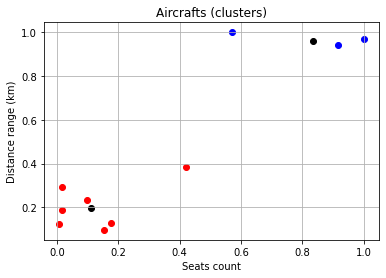

In [50]:
red = data_set[np.where(np.array(new_membership_fcm)[:,0]>0.5)]
blue = data_set[np.where(np.array(new_membership_fcm)[:,1]>0.5)]

fig, ax = plt.subplots()

ax.scatter(blue[:,0],blue[:,1],c='blue')
ax.scatter(red[:,0],red[:,1],c='red')
ax.scatter(np.array(new_centers_fcm)[:,0],np.array(new_centers_fcm)[:,1],c='black')
ax.set(xlabel='Seats count', ylabel='Distance range (km)',
       title='Aircrafts (clusters)')
ax.grid()
plt.show()

### Possibilistic k-means (PCM)

In the fuzzy version, each row sums to 1. In real-world cases, it doesn't need to be like this. The possibilistic k-means returns the distance to the center rather than dividing the membership between clusters.


As suggested by the authors, the initial membership matrix should be created using the FCM method. We do a fixed number of FCM method loops. The number of loops is set by the variable ``F``. The ``error_margin`` variable is the error threshold were below of it we stop the loop.

In [51]:
F = 2
error_margin = 0.08
membership = np.zeros((len(data_set),groups))

The membership function is more complex compared to the two previous one. In PCM we use the Mahalanobis distance instead of the Euclidean one, and the membership function is set as:
\begin{equation}
 \mu_{ik}=(1+(\frac{\rho_{A}(x_{i},v_{j})}{\eta_{i}})^{\frac{2}{m-1}})^{-1},
\end{equation}
where
\begin{equation}
\eta_{i}=\frac{\sum_{k=1}^{M}(\mu_{ik})^{m}\rho_{A}(x_{i},v_{j})}{\sum_{k=1}^{M}(\mu_{ik}
)^{m}}.
\end{equation}
$\rho_{A}(x_{i},v_{j})$ is the Mahalanobis distance:
\begin{equation}
\rho_{A}(x_{i},v_{j})=(x_{i}-v_{j})^{T}A(x_{i}-v_{j}).
\end{equation}
It use ``A`` diagnoal matrix to measure the distance. The figure below show how the euclidean distance is measured:
![](./../images/euclidean.png)
The difference between two distances is that in Mahalanobis distance we use the diagonal matrix ``A``, which is also known as Mahalanobis norm, that allow us to measure the distance between objects as it's shown in figure below.
![](./../images/mahalanobis.png)

The Mahalanobis norm can be implemented as below.

In [52]:
def calculate_A():
    mean = np.mean(data_set,axis=0)
    sumof = np.zeros((data_set[0].shape))
    for i in range(len(data_set)):
        subtracted = np.subtract(data_set[i],mean)
        sumof = sumof + np.multiply(subtracted, subtracted)
    variance = np.divide(sumof,len(data_set))
    ABcov = np.cov(data_set[:,0]*data_set[:,1])
    R = np.array([[variance[0], ABcov], [ABcov, variance[1]]])
    return R**-1

The matrix can be saved as global variable ``A``. It is the size of the feature number by feature number. In our case it will be a matrix of size $2\times2$.

In [53]:
A = calculate_A()
print(A)

[[7.89464944 6.69665317]
 [6.69665317 7.75894855]]


After getting the ``A`` matrix, we are able to calcualte the Mahalanobis distance. The ``A`` matrix is calculated once, because it depends on the whole data set, not the method steps.

In [54]:
def calculate_mah_distance(group, centers):
    dmc = data_set - centers[group]
    dmca = np.dot(data_set - centers[group], A)

    distances = lambda dmc, dmca: [np.dot(dmca[i], dmc[i]) for i in range(dmc.shape[0])]
    return distances(dmc,dmca)

The $\eta$ can be implemented as below:

In [55]:
def calculate_eta(membership, group, mah_distances):
    ud = np.sum((membership[:, group] ** m) * mah_distances, axis=0)
    uq = np.sum(membership[:, group] ** m, axis=0)
    return ud/uq

Finally, we can calculate the $\nu$:

In [56]:
def calculate_u_pcm(membership, centers):
    new_membership = np.zeros((len(data_set), groups))
    for group in range(groups):
        mah_distances = calculate_mah_distance(group, centers)
        group_eta = calculate_eta(membership, group, mah_distances)
        new_membership[:,group] = (1.0+(mah_distances/group_eta))**-1
    return new_membership

A stop function in PCM is defined as the difference between old and newly calculated centers.

In [57]:
def get_centers_difference(old_centers, new_centers):
    return np.sum(np.abs(np.subtract(old_centers,new_centers)))    

The ``cluster_pcm`` function has two parts. The first one is a FCM method that returns the input membership matrix for the PCM method.

In [58]:
def cluster_pcm(membership, centers):
    new_centers = centers
    new_membership = membership
    for f in range(F):
        membership = []
        for i in range(len(data_set)):
            membership_vector = []
            for k in range(groups): 
                membership_vector.append(calculate_u_fcm(data_set[i], new_centers, k))
            membership.append(membership_vector)
        new_centers = calculate_new_centers(membership)
        new_membership = np.array(membership)

        
    difference_limit_not_achieved = True
    while difference_limit_not_achieved:
        new_membership = calculate_u_pcm(new_membership, new_centers)
        old_centers = new_centers
        new_centers = calculate_new_centers(new_membership)

        if get_centers_difference(old_centers, new_centers) < error_margin:
            difference_limit_not_achieved = False
    return new_membership, new_centers

Now, we can cluster the data set with PCM:

In [61]:
new_membership_pcm, new_centers_pcm = cluster_pcm(membership, centers)

The membership values does not sum to 1 as in fuzzy k-means. The matrix give a better understanding of where the object is placed in the feature space.

In [62]:
pd.DataFrame(new_membership_pcm, columns = ['Cluster 1','Cluster 2'])

,Cluster 1,Cluster 2
0,0.525361,0.024211
1,0.765533,0.026526
2,0.920591,0.030403
3,0.883049,0.028066
4,0.958105,0.030211
5,0.967848,0.031339
6,0.013378,0.853996
7,0.011725,0.589741
8,0.020053,0.602404
9,0.114030,0.067536


In case of PCM we decided to extend the plot for many groups, up to 6. The colors are defined below.

In [63]:
assigned_groups = []
colors = ['red','blue','green','orange','black','yellow']

for el in range(len(data_set)):
    group_id = np.argmax(new_membership_pcm[el])
    assigned_groups.append(group_id)

We need a function that assign a color to each cluster.

In [64]:
def get_colours(color_id):
    return data_set[np.where(np.array(assigned_groups)[:]==color_id)]

Finally, we go through groups we have and assign objects to colors and plot it. What is important to mention is that some membership values for an object can be very low, means that this object is far from all centers. We can implement here a threshold where if all membership values are below some threshold we treat such objects as noise. In the figure below, we see the last object that is closer to the red centroid, but was assigned to the blue cluster. In this case both values are very low, but the blue one is just a bit higher. In a hard k-means method it wouldn't be so easy to find the noise.

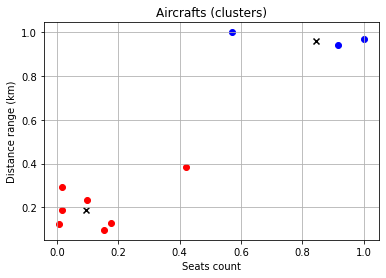

In [65]:
fig, ax = plt.subplots()


for group in range(groups):
    small_set = get_colours(group)    
    ax.scatter(small_set[:,0],small_set[:,1],c=colors.pop(0))
ax.scatter(np.array(new_centers_pcm)[:,0],np.array(new_centers_pcm)[:,1],marker='x',c='black')
ax.set(xlabel='Seats count', ylabel='Distance range (km)',
       title='Aircrafts (clusters)')
ax.grid()
plt.show()

## Density-based clustering

In density-based clustering the approach is different compared to distributed clustering. We need to implement all functions from scratch. The libraries that we are going to use are the same as in previous example, but in this case we have also the random package that is used to shuffle the objects in the data set.

DBScan is an example of a density-based clustering method. The goal is to find all element where the neighborhood is defined as:
\begin{equation}
    N_{\epsilon}:{q|d(p,q)\leq\epsilon},
\end{equation}
where $p$ and $q$ are two elements of the training data set and $\epsilon$ is the neighborhood distance. For the data set used before and $\epsilon$ to 0.25 we get the regions like in figure below.

![density](./../images/density.png)

Let's setup the variables as in previous examples. The are three new ones like ```distance_matrix```, ```max_distance```, ```number_of_cluster```, and ``min_points``. The first one is clear, the second is a parameter that can be changed, depending on that how many neighborhood elements we would like to concider. The next variable is about the number of clusters that are calculated during clustering. It's not the exact number of clusters, but allow us count the clusters during clustering. Last variable is the number of points that needs to within a neighbourhood to be classified as non-border object. Boarded points are the points that are the farest points from the cluster, but it's not the noise.

In [67]:
membership = np.zeros(len(X_norm))
distance_matrix = np.zeros((len(X_norm), len(X_norm)))
max_distance = 0.25
number_of_cluster = 0
min_points = 2

We need the distance function that we used in previous example to calculate the distance matrix:    

In [68]:
def calculate_distance(x,v):
    return sqrt((x[0]-v[0])**2+(x[1]-v[1])**2)

To calculate the distance matrix we use the calculate_distance that we used previously:

In [69]:
def calculate_distance_matrix():
    distance_matrix = np.zeros((len(data_set),len(data_set)))
    for i in range(len(data_set)):
        for j in range(len(data_set)):
            distance_matrix[i, j] = calculate_distance(data_set[i], data_set[j])
    return distance_matrix

The next step is to get closest elements in the feature space:

In [70]:
    def get_closest_elements(distance_matrix, element_id):
        element_distances = distance_matrix[element_id]
        filtered = {}
        iter = 0
        for element in element_distances:
            if element < max_distance:
                filtered[iter] = element
            iter = iter + 1
        return filtered

The last step before cluster function is to define funtions that mark the elements in our data set that are known to be a noise or were already visited by our method.

In [71]:
def set_as_noise(membership,element_id):
    membership[element_id] = -1
    return membership
    
def set_visited(elements, membership, number_of_clusters):    
    for element_id in elements.keys():
        membership[element_id] = number_of_clusters 
    return membership

Combine it all together:

In [72]:
def cluster_density(membership):
    number_of_cluster = 0
    distance_matrix = calculate_distance_matrix()
    element_ids = list(range(len(data_set)))
    random.shuffle(element_ids)
    for i in element_ids:
        if membership[i] != 0:
            continue
        closest = get_closest_elements(distance_matrix, i)
        if len(closest) < min_points:
            membership = set_as_noise(membership,i)
        else:
            membership = set_visited(closest, membership, number_of_cluster)
            number_of_cluster = number_of_cluster + 1
    return membership

Ready to cluster:

In [73]:
new_membership_density = cluster_density(membership)

The number of cluster is the size of unique cluster ids that are in ``new_membership_density`` minus noise.

In [74]:
print("Number of clusters: "+ str(len(np.unique(new_membership_density))-1))

Number of clusters: 2


The noise is marked with -1. The other objects have the cluster number assigned.

In [75]:
print(new_membership_density)

[ 1.  1.  1.  1.  1.  1.  2.  2. -1. -1.]


In [76]:
%store new_membership_density

Stored 'new_assignation_density' (ndarray)


## Hierarchical methods

We have two different types of hierarchical methods:
- agglomerative,
- divisive.

Both methods base on dendrograms, a structure that looks like a tree, dividing or merging the cluster at each level. The agglomerative method merge clusters until we get one cluster with all objects. The divisive method divide one cluster into two at each stage. We end if we get clusters where each consits of one object only.

In [80]:
def calculate_distance(x,v):
    return sqrt((x[0]-v[0])**2+(x[1]-v[1])**2)

### Agglomerative clustering

We need to keep the dendrogram and the history, so we can easily draw it.

In [81]:
%store -r data_set 

distance_matrix = np.zeros((len(data_set), len(data_set)))
current_dendrograms = [] 

for iter in range(len(data_set)):
    current_dendrograms.append(data_set[iter])

The tree object is the root where each edge is added.

In [82]:
tree = pydot.Dot(graph_type='graph')

In agglomerative we merge two clusters together on each step:

In [83]:
def merge_elements(current_dendrograms, merged_list, i):
    if isinstance(current_dendrograms[i][0], type(np.array([]))):
        for iter in range(len(current_dendrograms[i])):
            merged_list.append(current_dendrograms[i][iter])
    else:
        merged_list.append(current_dendrograms[i])
    return merged_list

We need to set the current dendrogram level at each step:

In [84]:
def set_current_dendrogram(current_dendrograms, dendrograms_hist, i, j):
    elements = []
    hist = []
    current_hist = dendrograms_hist[-1]
    for iter in range(len(current_dendrograms)):
        if iter != i and iter !=j:
            elements.append(current_dendrograms[iter])
            hist.append(current_hist[iter])
    merged_elements = []
    merged_elements = merge_elements(current_dendrograms, merged_elements, i)
    merged_elements = merge_elements(current_dendrograms, merged_elements, j)
    elements.append(merged_elements)
    hist.append([current_hist[i],current_hist[j]])
    dendrograms_hist.append(hist)
    current_dendrograms = elements
    return current_dendrograms, dendrograms_hist

At each stage a distance matrix needs to be calculated:

In [85]:
def calculate_dendogram_distance_matrix(current_dendrograms, distance_matrix):
    distance_matrix = np.zeros((len(current_dendrograms), len(current_dendrograms)))
    for i in range(len(current_dendrograms)):
        for j in range(len(current_dendrograms)):
            distance_matrix[i, j] = calculate_distance(calculate_centroid(current_dendrograms[i]),calculate_centroid(current_dendrograms[j]))
    return distance_matrix

The code abobve needs the centroids' average:

In [86]:
def calculate_centroid(dendrogram_elements):
    if type(dendrogram_elements) is list:
        sumof=np.zeros(len(dendrogram_elements[0]))
        for iter in range(len(dendrogram_elements)):
            sumof=np.add(sumof,np.array(dendrogram_elements[iter]))
        if sumof.shape == (len(data_set[0]),len(data_set[0])):
            pass
        return np.divide(sumof*1.0, len(dendrogram_elements)*1.0)
    else:
        return dendrogram_elements

For agglomerative we take the lowest distance from the distance matrix:

In [87]:
def get_lowest_from_distance_matrix(distance_matrix):
    lowest_indexes = [0,1]
    lowest_value = distance_matrix[0,1]
    for i in range(len(distance_matrix)):
        for j in range(len(distance_matrix)):
            if i != j:
                if lowest_value > distance_matrix[i,j]:
                    lowest_value = distance_matrix[i,j]
                    lowest_indexes = [i,j]
    return lowest_indexes

Combine it together:

In [88]:
def cluster_agg(current_dendrograms, distance_matrix):
    dendrograms_hist = [list(range(len(data_set)))]
    for iter in range(len(current_dendrograms)-1):
        distance_matrix = calculate_dendogram_distance_matrix(current_dendrograms, distance_matrix)
        [i, j] = get_lowest_from_distance_matrix(distance_matrix)
        current_dendrograms, dendrograms_hist = set_current_dendrogram(current_dendrograms, dendrograms_hist, i, j)
    return dendrograms_hist

And execute it:

In [89]:
dendrogram_hist_agg = cluster_agg(current_dendrograms, distance_matrix)

We use pydot to print the dendrogram:

In [95]:
def add_edge(level, acesor):
    if acesor != level:
        new_edge = pydot.Edge(str(acesor), str(level))
        tree.add_edge(new_edge)
    if isinstance(level,list):
        add_edge(level[0],level)
        add_edge(level[1],level)
        
def show_tree_agg():
    current_list = dendrogram_hist_agg.pop()
    root = current_list.pop()
    add_edge(root,root)
    tree.write('tree_agg.png',format='png')        

Take a look at tree_agg.png if generated.

In [99]:
show_tree_agg()

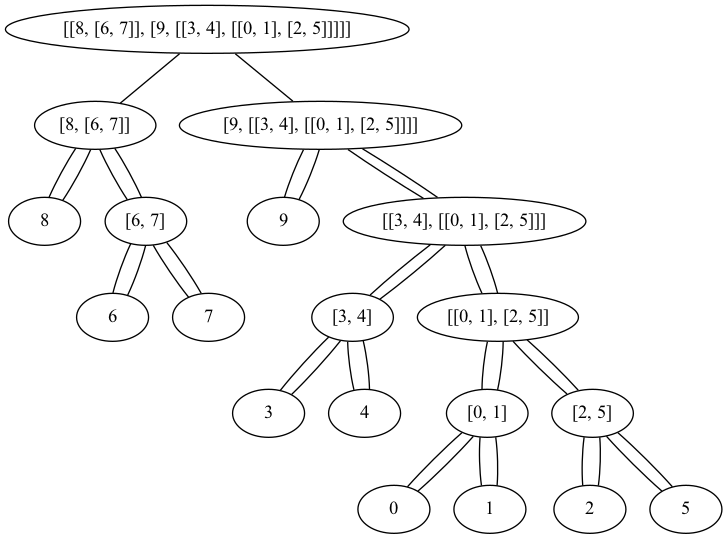

In [100]:
Image(filename='tree_agg.png') 

### Divisive clustering

Compared to the previous methods, we do the same, but in the opposite direction. We setup the same data, but the current dendrogram contains the whole data set as one cluster. 

In [101]:
tree = pydot.Dot(graph_type='graph')

We use a more efficient solution for the distance matrix calculation. In the following example, we calculate it once and extract the distances every time needed. This is why the below method is invoked only once.

In [102]:
def calculate_dendogram_distance_matrix_diana():
    distance_matrix=np.zeros((len(data_set), len(data_set)))
    for i in range(len(data_set)):
        for j in range(len(data_set)):
            distance_matrix[i, j] = calculate_distance(calculate_centroid(data_set[i]),calculate_centroid(data_set[j]))
    return distance_matrix

There are two new methods that needs to be implemented. The first one returns the cluster that needs to be divided:

In [103]:
def choose_cluster(current_level, distance_matrix):
    if type(current_level[0]) != list:
        both_idx = np.array(current_level)
        current = distance_matrix[both_idx[:,None], both_idx]
        diff = np.sum(current) / (current.shape[0] * current.shape[1] - len(current))
        return current_level, diff, 0
    highest_diff = 0
    cluster_id = 0
    for i in range(len(current_level)):
        both_idx = np.array(current_level[i])
        current = distance_matrix[both_idx[:, None], both_idx]
        diff = np.sum(current) / (current.shape[0] * current.shape[1]-len(current))
        if diff > highest_diff:
            highest_diff = diff
            cluster_id = i
    return current_level[cluster_id], highest_diff, cluster_id

The second method split the cluster into two clusters by counting the closest distances to each object in the cluster. Objects in both clusters are the closest ones.

In [104]:
def split(split_cluster, distance_matrix, diff):
    if len(split_cluster) == 2:
        cluster1 = [split_cluster[0]]
        cluster2 = [split_cluster[1]]
        return cluster1, cluster2
    split_threshold = diff
    both_idx = np.array(split_cluster)
    distances = distance_matrix[both_idx[:, None], both_idx]
    c1keys, c1counts = np.unique(np.argwhere(distances > split_threshold), return_counts=True)
    c2keys, c2counts = np.unique(np.argwhere(distances <= split_threshold), return_counts=True)
    cluster1_counts = dict(zip(np.array(split_cluster)[c1keys], c1counts))
    cluster2_counts = dict(zip(np.array(split_cluster)[c2keys], c2counts))
    cluster1 = []
    cluster2 = []
    choice = 0
    for item in split_cluster:
        if item not in cluster1_counts.keys():
            cluster2.append(item)
            continue
        if item not in cluster2_counts.keys():
            cluster1.append(item)
            continue
        if cluster1_counts[item] < cluster2_counts[item]:
            cluster2.append(item)
        elif cluster1_counts[item] > cluster2_counts[item]:
            cluster1.append(item)
        else:
            if choice == 0:
                cluster2.append(item)
                choice = 1
            else:
                cluster1.append(item)
                choice = 0
    return cluster1, cluster2

Combine it all together:

In [105]:
def cluster():
    dendrograms_history=[]
    current_dendrograms=[list(range(len(data_set)))]
    distance_matrix = calculate_dendogram_distance_matrix_diana()
    while len(current_dendrograms) != len(data_set):
        current_level = current_dendrograms[-1]
        current_cluster, diff, cluster_id = choose_cluster(current_level, distance_matrix)
        cluster1, cluster2 = split(current_cluster, distance_matrix, diff)
        if type(current_level[0]) != list:
            current_dendrograms.append([cluster1, cluster2])
        else:
            rest = current_level.copy()
            rest.pop(cluster_id)
            rest.append(cluster1)
            rest.append(cluster2)
            current_dendrograms.append(rest)
        hist = [{"acesor": current_cluster, "childs": [cluster1,cluster2]}]
        dendrograms_history.append(hist)
    return dendrograms_history

We get the dendrogram levels with:

In [106]:
dendrogram_hist_diana = cluster()

%store dendrogram_hist_diana

Stored 'dendrogram_hist_diana' (list)


/var/folders/p4/6h9d2vxd05j4lwqtfwfw5c2h0000gn/T/ipykernel_44622/685288020.py:12: RuntimeWarning: invalid value encountered in scalar divide
  diff = np.sum(current) / (current.shape[0] * current.shape[1]-len(current))


The method that draw the dendrogram is a bit different compared to the agglomerative method:

In [107]:
def show_tree_divisive():
    for item in dendrogram_hist_diana:
        for child in item[0]["childs"]:
            new_edge = pydot.Edge(str(item[0]["acesor"]),str(child))
            tree.add_edge(new_edge)
    tree.write('tree_diana.png',format='png')

In [108]:
show_tree_divisive()

We can display the dendrogram the same as in the previous example:

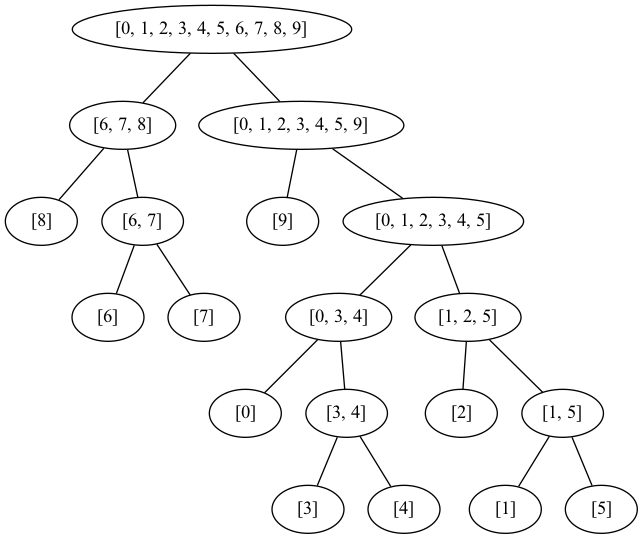

In [109]:
Image(filename='tree_diana.png') 

## Clustering quality metrics

We can divide the clustering quality metrics into two groups: internal and external indicies. Internal indicies base only on the the clustered data without a clustered version that we could benchmark with. In other words, we don't have labelled/clustered data to compare with. In external indicies we have the information about the expected output and we are able to calculate metrics like accuracy, f1-score and other known from supervised learning.

In this section we focus on internal indicies only. We can group internal indicies into two groups:
- heterogeneity,
- homogeneity.
Four heterogeneity and two homogeneity methods are presented in this notebook. 

In [110]:
def calculate_distance(x,v):
    return sqrt((x[0]-v[0])**2+(x[1]-v[1])**2)

### Data set

We compare two data sets, both are a results of HCM method. The first one is a HCM that divided the data set into two groups. We just restore the variable ``new_membership_hcm`` and ``new_centers_hcm``. We have set two other variable of possible clustering for three groups and saved the results in ``new_membership_hcm3`` and ``new_centers_hcm3``.

In [111]:
%store -r new_membership_hcm
%store -r new_centers_hcm
%store -r data_set

new_membership_hcm = np.array(new_membership_hcm)
new_centers_hcm = np.array(new_centers_hcm)

new_membership_hcm3 = np.array([[0., 1., 0.],[0., 1., 0.], [0., 1., 0.],[0., 1., 0.], [0., 1., 0.], [0., 1., 0.], [0., 0., 1.], [0., 0., 1.], [0., 0., 1.], [1., 0., 0.]])
new_centers_hcm3 = np.array([[0.42239686, 0.38503185],[0.07858546, 0.17832272],[0.82907662, 0.97059448]])

### Homogeneity and heterogeneity

We have four separation measures $s_{1}(c_{i},c_{j})$, $s_{2}(c_{i},c_{j})$,
$s(s_{1})$ and $s(s_{2})$. The first two separation measures explain how far from each other the clusters are. We take the objects in each cluster and measure the distances between each object of two different clusters. 

The metric $s_{1}$ can be calculate as following:
\begin{equation}
 s_{1}(c_{i},c_{j})=\frac{1}{n_{i}n_{j}}\sqrt{\sum_{x_{1},\in c_{i},x_{2}\in c_{j}}d^{2}(x_{1},x_{2})}.
\end{equation}
This measure can be implemented as below.

In [112]:
def calculate_s_1(centers,membership):
    s1 = []
    for center_1 in range(len(centers)):
        for center_2 in range(len(centers)):
            if center_1 == center_2:
                break
            ids_1 = np.where(membership[:, center_1] == 1)[0]
            ids_2 = np.where(membership[:, center_2] == 1)[0]
            elements_1 = data_set[ids_1]
            elements_2 = data_set[ids_2]
            s_1 = 1.0 / (len(ids_1) * len(ids_2))
            for element_1 in elements_1:
                for element_2 in elements_2:
                    s_1 = s_1 * sqrt(calculate_distance(element_1, element_2) ** 2)
            s1.append(s_1)
    return s1

We take two objects, each from different cluster and calculate the power distance measure. Next, we sum all the distances from object of two clusters and calculate a square root of it. The value is then divided by the multiplication of the counts of objects in both clusters. The higher value is better.

In [113]:
s1_2 = calculate_s_1(new_centers_hcm,new_membership_hcm)
s1_3 = calculate_s_1(new_centers_hcm3,new_membership_hcm3)

print(s1_2)
print(s1_3)

[0.10062820443387574]
[0.0007587103186922478, 0.12913857784026206, 0.3030325350305444]


The best clusters are the first compared to the second in the thre group clustering. 

The second separation measure is about the distance between two centers only:
\begin{equation}
 s_{2}(c_{i},c_{j})=d(c_{i},c_{j}).
\end{equation}
It is the simplest measure and it can be implemented as below.

In [114]:
def calculate_s_2(centers):
    s2 = []
    for center_1 in range(len(centers)):
        for center_2 in range(len(centers)):
            if center_1 == center_2:
                break
            s2.append(calculate_distance(centers[center_1], centers[center_2]))
    return s2

The same as the previous metric, higher values means a better cluster.

In [115]:
s2_2 = calculate_s_2(new_centers_hcm)
s2_3 = calculate_s_2(new_centers_hcm3)

print(s2_2)
print(s2_3)

[1.0361961303876361]
[0.40116697670087065, 0.7129319889345509, 1.0912980907761376]


A different metric is the $\sigma_{1}$ which does not take the centers into consideration. It measures the distances between each object within a cluster. The smaller value here the better cluster it is. The metric is defined as:

\begin{equation}
 \sigma_{1}(c_{i})=\frac{1}{m}\sum_{x_{1}, x_{2}\in c_{i}}d^{2}(x_{1},x_{2}),
\end{equation}

where the $m$ is defined as 

\begin{equation}
 m=\frac{(n_{i}-1)n_{i}}{2}.
\end{equation}

In [116]:
def calculate_sigma_1(membership):
    sigma_1 = []
    unique_labels = len(membership[0])
    for label_id in range(unique_labels):
        ids = np.where(membership[:, label_id] == 1)[0]
        if len(ids) == 1:
            sigma_1.append(1.0)
            continue
        else:
            m = (len(ids) - 1.0) * len(ids) / 2.0
        elements = data_set[ids]
        sigma = (1.0 / m)
        for element_x_1 in range(len(elements)):
            for element_x_2 in range(len(elements)):
                if element_x_1 == element_x_2:
                    continue
                distance = calculate_distance(elements[element_x_1], elements[element_x_2])
                if distance != 0:
                    sigma = sigma + (distance ** 2)
        sigma_1.append(sigma)
    return sigma_1

The results are given for each cluster. That's why we have only two values in the first cases, and three in the second list. Lower value means a better cluster.

In [117]:
sigma1_2 = calculate_sigma_1(new_membership_hcm)
sigma1_3 = calculate_sigma_1(new_membership_hcm3)

print(sigma1_2)
print(sigma1_3)

[2.775635895144805, 0.9686234538734891]
[1.0, 0.7496360155982489, 0.9686234538734891]


In the metric $s(s_{1})$ we take two previously calculated values:
\begin{equation}
 s(s_{1})=\sum_{i,j=1;j\neq i}^{K}\frac{s_{1}(c_{i},c_{j})}{\sigma_{1}(c_{i})}.
\end{equation}
This measure is a bit more complex and it measure the relation between the distances of objects within a cluster and distnaces between objects in two clusters. Higher values means a better cluster, but it takes the relation between two clusters as a result.

In [118]:
def calculate_s_s_1(s1, sigma_1):
    s_1_sum = 0.0
    sigma_1_sum = 0.0
    for s_1 in s1:
        s_1_sum = s_1_sum + s_1
    for sigma_1 in sigma_1:
        sigma_1_sum = sigma_1_sum + sigma_1
    s_s1 = s_1_sum / sigma_1_sum
    return s_s1

The results below makes it clear that three clusters solution is better than two. Usually it is that increasing the number of clusters increase the value of this metric.

In [119]:
s11_2 = calculate_s_s_1(s1_2,sigma1_2)
s11_3 = calculate_s_s_1(s1_3,sigma1_3)

print(s11_2)
print(s11_3)

0.026875329685765333
0.1592672914604556


The metric $\sigma_{2}$ measures the distances between objects within a cluster and the center of this cluster. It is defined as:
\begin{equation}
 \sigma_{2}(c_{i})=\frac{1}{n_{i}}\sum_{x\in c_{i}}d^{2}(x,c_{i}).
\end{equation}
It can be implemented as:

In [120]:
def calculate_sigma_2(centers, membership):
    sigma_2 = []
    for center_id in range(len(centers)):
        ids = np.where(membership[:, center_id] == 1)[0]
        elements = data_set[ids]
        sigma = 1.0 / len(ids)
        for element_id in range(len(elements)):
            distance = calculate_distance(elements[element_id], centers[center_id])
            if distance != 0:
                sigma = sigma + (distance) ** 2
        sigma_2.append(sigma)
    return sigma_2

Lower value means a better cluster. We get a list of values for each cluster. In our case the second cluster in the three cluster approach is the best one.

In [121]:
sigma2_2 = calculate_sigma_2(new_centers_hcm, new_membership_hcm)
sigma2_3 = calculate_sigma_2(new_centers_hcm3, new_membership_hcm3)

print(sigma2_2)
print(sigma2_3)

[0.3377154891089826, 0.4392150200900259]
[1.0, 0.22358077907763185, 0.4392150200900259]


### Other internal indices

The Dunn index says what is the relation between the minimal distance of objects within a cluster and the maximum distance of objects within a cluster. It gives a better understanding of how far are the objects from each other. It can be easily calculated as a quotient of two distances:
\begin{equation}
 C=\frac{d_{min}}{d_{max}},
\end{equation}
where the equations of $d_{max}$ and $d_{min}$ are like following:
\begin{equation}
 d_{max}=\max_{1\leq k\leq K}D_{k},\\
\end{equation}
and
\begin{equation}
 d_{min}=\min_{k\neq k'} d_{k}.
\end{equation}

Both distances are just the minimum and maximum euclidean distances between objects. The minimum distance is a measure of two object that are in different clusters:
\begin{equation}
 d_{k}=\min_{i,j\in I_{k}; i\neq j}d(x_{i}^{(k)}-x_{j}^{(k')}).
\end{equation}
The clusters are marked with $k$ and $k'$. The maximum distance takes the distance of two objects within a cluster:
\begin{equation}
 D_{k}=\max_{i,j\in I_{k}; i\neq j}d(x_{i}^{(k)}-x_{j}^{(k)}).
\end{equation}
It can be implemeneted as:

In [122]:
def dunn_index(membership):
    minimum_distance = 1
    maximum_distance = 0
    unique_labels = np.unique(membership[0])
    for label_id_1 in range(len(unique_labels)):
        ids_1 = np.where(membership[:, label_id_1] == 1)[0]
        for label_id_2 in range(len(unique_labels)):
            if label_id_1 == label_id_2:
                break
            ids_2 = np.where(membership[:, label_id_2] == 1)[0]
            for element_1 in data_set[ids_1]:
                for element_2 in data_set[ids_2]:
                    distance = calculate_distance(element_1, element_2)
                    if distance > maximum_distance:
                        maximum_distance = distance
                    if distance < minimum_distance:
                        minimum_distance = distance
    dunn_index = minimum_distance / maximum_distance
    return dunn_index

The values of Dunn index for our examples are given below. In this case a higher values means a better clustering result.

In [123]:
dunn2 = dunn_index(new_membership_hcm)
dunn3 = dunn_index(new_membership_hcm3)

print(dunn2)
print(dunn3)

0.48534159949891914
0.7224828783672833


## Image segmentation

Clustering is commonly used for image segmentation. The goal of image segmentation is to divide the image into similar regions. Usually it's done by finding the most similar colors - grouping colors used in image into clusters. In the example below we implement two classes: ``ImageConversion`` and ``Segmentation``.

Before we go to the implementation part, we need to import several packages. We use the same that are used in the hard k-means example like numpy and math for calculation. The random package is used for intializing random centers and math is used for the Euclidean distance. 

The ``ImageConersion`` class has three methods:
- ``get_image_from_url`` - load the image,
- ``get_unique_colours`` - find all unique colors in an image,
- ``save_image`` - save the segmented image.

We get all unique colors because of performance reasons.

In [124]:
class ImageConversion:

    def get_image_from_url(self, img_url):
        image = open(img_url,'rb')
        return img.imread(image)

    def get_unique_colours(self, image_matrix):
        feature_matrix = []
        for i in range(len(image_matrix)):
            for j in range(len(image_matrix[0])):
                feature_matrix.append(image_matrix[i, j])
        feature_matrix_np = numpy.array(feature_matrix)
        uniques, index = numpy.unique([str(i) for i in feature_matrix_np], return_index=True)
        return feature_matrix_np[index], feature_matrix

    def save_image(self, size, pixel_matrix, unique_matrix, membership_matrix, colours, output):
        image_out = Image.new("RGB", size)
        pixels = []
        for i in range(len(pixel_matrix)):
            pixel_list = pixel_matrix[i].tolist()
            for j in range(len(unique_matrix)):
                if(pixel_list == unique_matrix[j].tolist()):
                    for k in range(len(colours)):
                        if membership_matrix[j][k] == 1:
                            segmented_colours=[int(i) for i in (colours[k]*255)]
                            pixels.append(tuple(segmented_colours))
        image_out.putdata(pixels)
        image_out.save(output)

The ``Segmentation`` class has the same methods as hard k-means. The membership matrix is related to the number of unique colors in the image. Centers are set in the RGB color space. 

In [125]:
class Segmentation:

    def __init__(self, feature_matrix, groups):
        self.__data_set = feature_matrix
        self.__groups = groups
        self.__space=[[0, 255], [0, 255], [0, 255]]
        self.__error_margin = 0.5
        self.membership = numpy.zeros((len(self.__data_set), self.__groups))
        self.centers = []
        self.select_centers()

    def select_centers(self):
        if len(self.centers) == 0:
            iter=0
            while iter<self.__groups:
                self.centers.append(((random.randrange(0, 255)*1.0/255),
                                     (random.randrange(0, 255)*1.0/255),
                                     (random.randrange(0, 255)*1.0/255)))
                iter=iter+1

    def calculate_distance(self, x, v):
        return math.sqrt((x[0]-v[0])**2+(x[1]-v[1])**2+(x[2]-v[2])**2)

    def calculate_u(self, x, i):
        smallest_distance = float(self.calculate_distance(x, self.centers[0]))
        smallest_id = 0
        for i in range(1, self.__groups):
            distance = self.calculate_distance(x, self.centers[i])
            if distance < smallest_distance:
                smallest_id = i
                smallest_distance = distance
        distance = numpy.zeros(self.__groups)
        distance[smallest_id]=1
        return distance

    def calculate_new_centers(self, u):
        new_centers=[]
        for c in range(self.__groups):
            u_x_vector = numpy.zeros(len(self.centers[0]))
            u_scalar = 0
            for i in range(len(u)):
                u_scalar = u_scalar + u[i][c]
                u_x_vector = numpy.add(u_x_vector, numpy.multiply(u[i][c], self.__data_set[i]))
            new_centers.append(numpy.divide(u_x_vector,u_scalar))
        print(new_centers)
        self.centers = new_centers

    def calculate_differences(self,new_membership):
        diff=0
        for i in range(len(self.membershipn)):
            for j in range(self.__groups):
                diff = diff + abs(float(new_membership[i][j]) - float(self.membership[i][j]))
        return diff

    def do_segmentation(self):
        difference_limit_not_achieved = True
        iter = 0
        while difference_limit_not_achieved:
            new_membership = []
            for i in range(len(self.__data_set)):
                new_membership.append(self.calculate_u(self.__data_set[i], iter))
            self.calculate_new_centers(new_assignation)

            if iter > 0:
                if self.calculate_differences(new_membership) < self.__error_margin:
                    difference_limit_not_achieved=False
            self.membership = new_membership
            iter = iter + 1

    def get_results(self):
        return self.centers, self.membership

Finally, we can use it with clustering for image segmentation.  In the first place we load the image and get the list of unique colors. Next, we set the number of clusters (``groups``). The segmentation part takes the unique colors, put it into a three-dimensional space and find centers of three clusters. It returns the membership matrix with a cluster id assgined to each color. The image is saved based on the colors of centers assigned to each colors. Each pixel of a given color is replaced with the colors of the center of assigned cluster. 

In [134]:
import os

image_to_segment = os.getcwd()+"./../images/logo_krakow.png"
image_to_segment = os.getcwd()+"/../images/logo_krakow.png"
image_converter = ImageConversion()
image_data = image_converter.get_image_from_url(image_to_segment)
unique_image_data, image_data_list = image_converter.get_unique_colours(image_data)

groups = 3

if image_data.shape[2] > 3:
    image_data = image_data[:,:,[0,1,2]]
    unique_image_data = unique_image_data[:,[0,1,2]]
    image_data_list = numpy.array(image_data_list)[:,[0,1,2]]

segmentation = Segmentation(unique_image_data, groups)
segmentation.do_segmentation()
centers, membership_matrix = segmentation.get_results()

image_size = (232, 258)
image_converter.save_image(image_size, image_data_list, unique_image_data, membership_matrix, centers, "../images/segmented.png")

NameError: name 'img' is not defined

The centers represents the values in RGB:

In [ ]:
centers

We can easily draw the three-dimensional feature space with all unique colors drawn as points, and centers as black squares.

In [ ]:
%matplotlib inline

fig = pyplot.figure()
ax = Axes3D(fig)
#ax.set_aspect("equal")
x_centers = [item[0] for item in centers]
y_centers = [item[1] for item in centers]
z_centers = [item[2] for item in centers]

x_values = [item[0] for item in unique_image_data]
y_values = [item[1] for item in unique_image_data]
z_values = [item[2] for item in unique_image_data]
ax.scatter(x_values, y_values, z_values, c=numpy.array(unique_image_data),alpha=0.5)

ax.scatter(x_centers, y_centers, z_centers, c='black',marker='s',alpha=1)

ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')

pyplot.show()

The converted image is given as below. We see that there are only three colors in the image.

In [ ]:
Image("../images/segmented.png")